# Real or Not? NLP with Disaster Tweets 
### Natural Language Processing & Text

#### by: Francisco Fortes & Tamara Qassem

## Introduction

Twitter is one of the biggest social media platforms in the world. This platform has become one of the most important communication channels in times of emergency. With the wide access that smartphones have to the internet, people can announce at their own will an emergency, whether if it is true or not, in real-time. Because of this phenomena, many companies and other organizations are very interested in analaysing and monitoring Twitter.
This is where natural language processing tools might come in hand when soving trivial problems such as this one. Most of the times it is hard to determine if a "tweet" is talking about a disaster or other non-related phenomena. Therefore we need to create tools to help us analyse text and allow us to better comprehend the intent of a message and the credability of the message that was tweeted.


## 1) Loading Libraries
Before importing the data given to us we will be importing some useful libraries that might help us solve this "machine learning" problem.

In [1]:
# Imports
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import re
import nltk
import string
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
from collections import defaultdict
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics 
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, layers, regularizers, constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import itertools
import collections

## 2) Loading Data
The "Real or Not? NLP with Disaster Tweets" Kaggle dataset has been presented to us in two separate datasets: one for training, and another for the testing.

In [2]:
train_df = pd.read_csv("/Users/kuka/Desktop/NLP/Data/train.csv", dtype={'id': np.int16, 'target': np.int8})
test_df = pd.read_csv("/Users/kuka/Desktop/NLP/Data/test.csv", dtype={'id': np.int16, 'target': np.int8})
sample_submission = pd.read_csv('/Users/kuka/Desktop/NLP/Data/sample_submission.csv')

## 3) Baseline Model
Before conducting an exploratory data analysis and conduct all the pre-processing steps into our model we have decided to conduct a quick baseline model, without changing any variables. We have done this in order to understand the minimum boundary accurarcy score that our model currently holds, for this baseline model we have decided to use a Naive Bayes model, which is one of the most used models in Machine Learning and in Natural Language Processing.


First, we need to intialize a CountVectorizer( ) object. A count vectorizer will allow us, in a simple way, to tokenize all of our tweets and build a vocabulary of known words, plus it will allow us to encode new documents using this vocabulary.In other words it will create a vector that has a dimensionality equivalent to the size of our tweets vocabulary, and if the tweets feature that word, python will allocate a "1" to that dimension. Every time that we encounter that word again, the count will increase by "1", leaving "0's" where we don't find a word.

In [3]:
#Here we are initializing the CountVectorizer() object
count_vectorizer = CountVectorizer()

Secondly, we will fit & transform in order to create a Bag of Words (BoW) dictionary and vectors for each document using the train set and we will just apply a transformation into our test data to create a BoW vector using the same dictionary as we used in the training set.

In [4]:
#For the count_vectorizer class fit_tranform will create the bag of words dictionary and vectors for each 
#document using the training data 
count_train = count_vectorizer.fit_transform(train_df['text'])

#We call transform on the test data to create bag of words vectors using the same dictionary
count_test = count_vectorizer.transform(test_df['text'])

Lastly, we will be preforming our Naive Bayes model and checking the accuracy that we get for our baseline model. For this model and as for the other models that we will preform more towards the end of this assignment we have assigned our target variable to the feature 'target' that is availble on this dataset, this variable has two possible out comes:
- **0 :** Non-disaster tweet related
- **1 :** Disaster tweet related

In [5]:
#Performing simple Naive Bayes model and checking the accuracy
target = train_df['target']
X_train, X_test, Y_train, Y_test = train_test_split(count_train,target,test_size=0.2,train_size=0.8, random_state = 40)

#Initializing our class and calling fit without training data
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, Y_train)

#Predict will use the trained model to predict the label based on the test data vectors
pred = nb_classifier.predict(X_test)

#Evaluating model performance
metrics.accuracy_score(Y_test, pred)

0.8030203545633617

As seen above we got a baseline score of 80.6%, which is pretty good for a model that doesn't have any text pre-processing or any cleaning on it. But in the context of NLP we believe that this is bad because let's say that we have a tweets of 100 words on average, this means that on average we have almost 20 words in this text that are wrongly labelled in the type of tweet.

In [6]:
metrics.confusion_matrix(Y_test, pred, labels=[0,1])

array([[728, 124],
       [176, 495]])

If we have a brief look at the confusion matrix above, the  predicted labels are shown accross at the top of the matrix, 773 and 113, respectively, and the true labels are shown on the down side, 182 and 455, respectively. For example, this shows to us that we have disaster 182 tweets that are incorrectly labelled as non-disaster and 113 non-disaster tweets that are incorrectly labelled as disaster tweets.

Therefore we can see from the distribuition of true positives and negatives that our dataset is a bit skewed.

## 4) Exploratory Data Analysis (EDA)

For this exploratory data analysis section of our assignment on this Tweets we are going to analyse some meta features that could be very useful to help us identify disaster tweets.
For example, it is common knowledge that "fake news" headlines usually tend to use lesser common nouns and more proper nouns than mainstream news headlines. Also we believe that disaster tweets usually tend to be written more formally (due to formality of the news agencies) when compared to non-disaster tweet. Non-disaster tweets also tend to have more typo errors because they are coming from individuals, news agencies can't "afford to make typo errors when reporting important news.
Therefore for this analysis we are going to focus on the following meta features:
- **"missing_values":** checking for missing values in our datasets.
- **"unique_values & target distribuition":** checking for unique values and the distribuition of the target.
- **"word_count":** number of words in a tweet (text).
- **"unique_word_count":** number of different/unique words in a tweet.
- **"Avg_word_density:** mean character count in words.
- **"stop_word_count":** number of stop word in a tweet.
- **"charc_count":** number of characters in a tweet.
- **"Punct_count":** number of punctuations in a tweet.
- **"hashtag_count":** number of hashtags ("**#**") in a tweet.
- **"mention_count":** number of mentiones ("**@**") in a tweet.
- **"url_count":** number of URL links in a tweet.
- ???**Frequency Distribuition of POS Tag:** noun, ver, proverb, adjectives, etc

In [7]:
## Making a copy of the dataframe in order not to manipluate the original csv file
train = train_df.copy()
test = test_df.copy()

### 4.1) Checking for missing values
So now we will be checking for missing values in our train and test datasets.

In [8]:
def missing_values (x):
    missing_values = x.isnull().sum()
    return (missing_values)

In [9]:
def percentage_nulls (x):
    percentage_nulls = round(x.isnull().sum() * 100 / len(x),2)
    return (percentage_nulls)

#### Trainining set
According to the values we have seen below we have 61 and 2533 null values for keyword and location, respectively.

In [10]:
missing_values(train)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

As seen for the training set we have missing values for **keyword** and **location**:
- **0.8%** of keywords values are missing.
- **33%** of location values are missing.

In [11]:
percentage_nulls(train)

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

#### Test set
According to the values we have seen below we have 26 and 1105 null values for keyword and location, respectively.

In [12]:
missing_values(test)

id             0
keyword       26
location    1105
text           0
dtype: int64

As seen for the test set we have missing values for **keyword** and **location**:
- **0.8%** of keywords values are missing.
- **33%** of location values are missing.

In [13]:
percentage_nulls(test)

id           0.00
keyword      0.80
location    33.86
text         0.00
dtype: float64

As we are able to witness, in the training and test set we have the same ratio of missing balues in **keyword** and **location**, therefore since the ratios between this two sets are close, we could assume that most probably both are taken from the same sample.

### 4.2) Unique values & Target Distribuition
As we know tweets are dependents on the user, they are dependent whether the user decides to tag/mention(@) someone, use hashtags (#) or upload the location of the event. 

Therfore things like **location** are not automatically generated by Twitter, the user who's posting the tweet needs to insert the location, therefore this factor is user-dependent. This is why the feature location is "messy" and there are many unique values in in it, therefore for the sake of our analysis in the upcomming section, we shouldn't maybe include this variable.
But in our "favour" we can use the feature **keyword** for our analysis because some of the keywords avaible to us can be just used in one particular context, in other words, there aren't multiple meanings. This feature could possibly be used in our later analysis asa word by itself or as a word in a text. Also every single keyword in the training set exists in the test set, if both are from the same sample (obviously). Also it is possible for us to use target encoding on this feature.

In [14]:
def unique_values (x,col):
    unique_values = x[col].nunique()
    return (unique_values)

In [15]:
print(f'Number of unique values in keyword= Training: {unique_values(train,"keyword")} & Test: {unique_values(test,"keyword")}')
print(f'Number of unique values in keyword= Training: {unique_values(train,"location")} & Test: {unique_values(test,"location")}')

Number of unique values in keyword= Training: 221 & Test: 221
Number of unique values in keyword= Training: 3341 & Test: 1602


### 4.3) Word Count
On this section we have created a new column, named 'word_count' where we  will be counting the number of words in a tweet (text).

In [16]:
def word_count(df):
    # Split the string into words 
    words = df.split()
    # Return length of words list
    return len(words)

In [17]:
train['word_count'] = train['text'].apply(word_count)

In [18]:
test['word_count'] = test['text'].apply(word_count)

### 4.4) Unique Word Count
On this section we have created a new column, named 'unique_word_count' where we  will be counting the number of different/unique words in a tweet (text).

In [19]:
def unique_word_count(df):
    unique= df.apply(lambda x: len(set(str(x).split())))
    return (unique)

In [20]:
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))

In [21]:
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

### 4.4) Average Word Density
On this section we have created a new column, named 'avg_word_count' where we will be counting the average number of words in tweet (text).

In [22]:
def avg_word_desnsity(df):
    # Split the string into words
    words = df.split()
    # Compute length of each word
    lenght_words = [len(w) for w in words]
    # Compute average word length
    avg_word_length = round(sum(lenght_words)/len(words))
    # Return average word length
    return (avg_word_length)

In [23]:
train['avg_word_length'] = train['text'].apply(avg_word_desnsity)

In [24]:
test['avg_word_length'] = test['text'].apply(avg_word_desnsity)

### 4.5) Stop Word Count
On this section we have created a new column, named 'stop_word_count' where we will be counting the number of stop words in a tweet (text).

In [25]:
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [26]:
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

### 4.6) Character Count
On this section we have created a new column, named 'char_count' where we will be counting the number of characters in words.

In [27]:
def char_count(x):
    char_num = len(x)
    return (char_num)

In [28]:
train['char_count'] = train['text'].apply(char_count)

In [29]:
test['char_count'] = test['text'].apply(char_count)

### 4.7) Punctuation Count
On this section we have created a new column, named 'punct_count' where we will be counting the number of punctuation symbols in a tweet (text).

In [30]:
train['punct_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [31]:
test['punct_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

### 4.8) Hashtag Count
On this section we have created a new column, named 'hashtag_count' where we will be counting the number of "**#**" symbols in a tweet (text).

In [32]:
train['hashtag_count'] = train['text'].apply(lambda x: len([sym for sym in str(x) if sym == '#']))

In [33]:
test['hashtag_count'] = test['text'].apply(lambda x: len([sym for sym in str(x) if sym == '#']))

### 4.8) Mentions Count
On this section we have created a new column, named 'mention_count' where we will be counting the number of "**@**" symbols in a tweet (text).

In [34]:
train['mention_count'] = train['text'].apply(lambda x: len([sym for sym in str(x) if sym == '@']))

In [35]:
test['mention_count'] = test['text'].apply(lambda x: len([sym for sym in str(x) if sym == '@']))

### 4.9) URL Count
On this section we have created a new column, named 'url_count' where we will be counting the number of url links in a tweet (text).

In [36]:
train['url_count'] = train['text'].apply(lambda x: len([url for url in str(x).lower().split() if 'http' in url or 'https' in url]))

In [37]:
test['url_count'] = test['text'].apply(lambda x: len([url for url in str(x).lower().split() if 'http' in url or 'https' in url]))

### 4.10) Frequency Distribuition Most Common Words 
On this section we will be observing the most common words used in tweets.

In [38]:
words_in_tweet = [tweet.lower().split() for tweet in train.text]

In [39]:
words_in_tweet[:2]

[['our',
  'deeds',
  'are',
  'the',
  'reason',
  'of',
  'this',
  '#earthquake',
  'may',
  'allah',
  'forgive',
  'us',
  'all'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask.', 'canada']]

In [40]:
all_words = list(itertools.chain(*words_in_tweet))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(25)

[('the', 3207),
 ('a', 2135),
 ('in', 1949),
 ('to', 1934),
 ('of', 1814),
 ('and', 1405),
 ('i', 1336),
 ('is', 930),
 ('for', 880),
 ('on', 834),
 ('-', 763),
 ('you', 746),
 ('my', 671),
 ('with', 562),
 ('that', 538),
 ('at', 532),
 ('by', 514),
 ('it', 504),
 ('this', 463),
 ('from', 420),
 ('are', 397),
 ('be', 396),
 ('was', 381),
 ('have', 380),
 ('like', 341)]

In [41]:
clean_tweets = pd.DataFrame(counts.most_common(50),
                             columns=['words', 'count'])

clean_tweets.head(10)

,words,count
0,the,3207
1,a,2135
2,in,1949
3,to,1934
4,of,1814
5,and,1405
6,i,1336
7,is,930
8,for,880
9,on,834


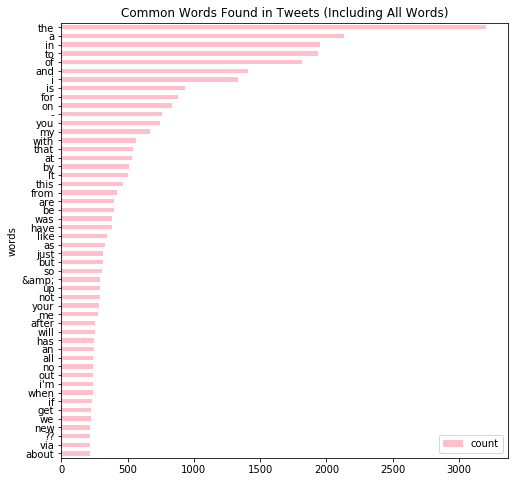

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="pink")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

As we may observe many most of the used/ frequent words on our dataset are stopwords.

### 4.11) Graphical Analysis on Target

First, let's create two separate lists: one that includes all the new meta_features that we have created prior to this graphical analysis and one we our target variable, **'target'**.

In [43]:
meta_features= ['word_count','unique_word_count','avg_word_length', 'stop_word_count',
                'char_count', 'punct_count', 'hashtag_count', 'mention_count', 'url_count']

disaster = train['target'] == 1

Secondly, let's now create the frequency distribuition plots where we will be able to compare in more detail each meta feature created in two separate plots.

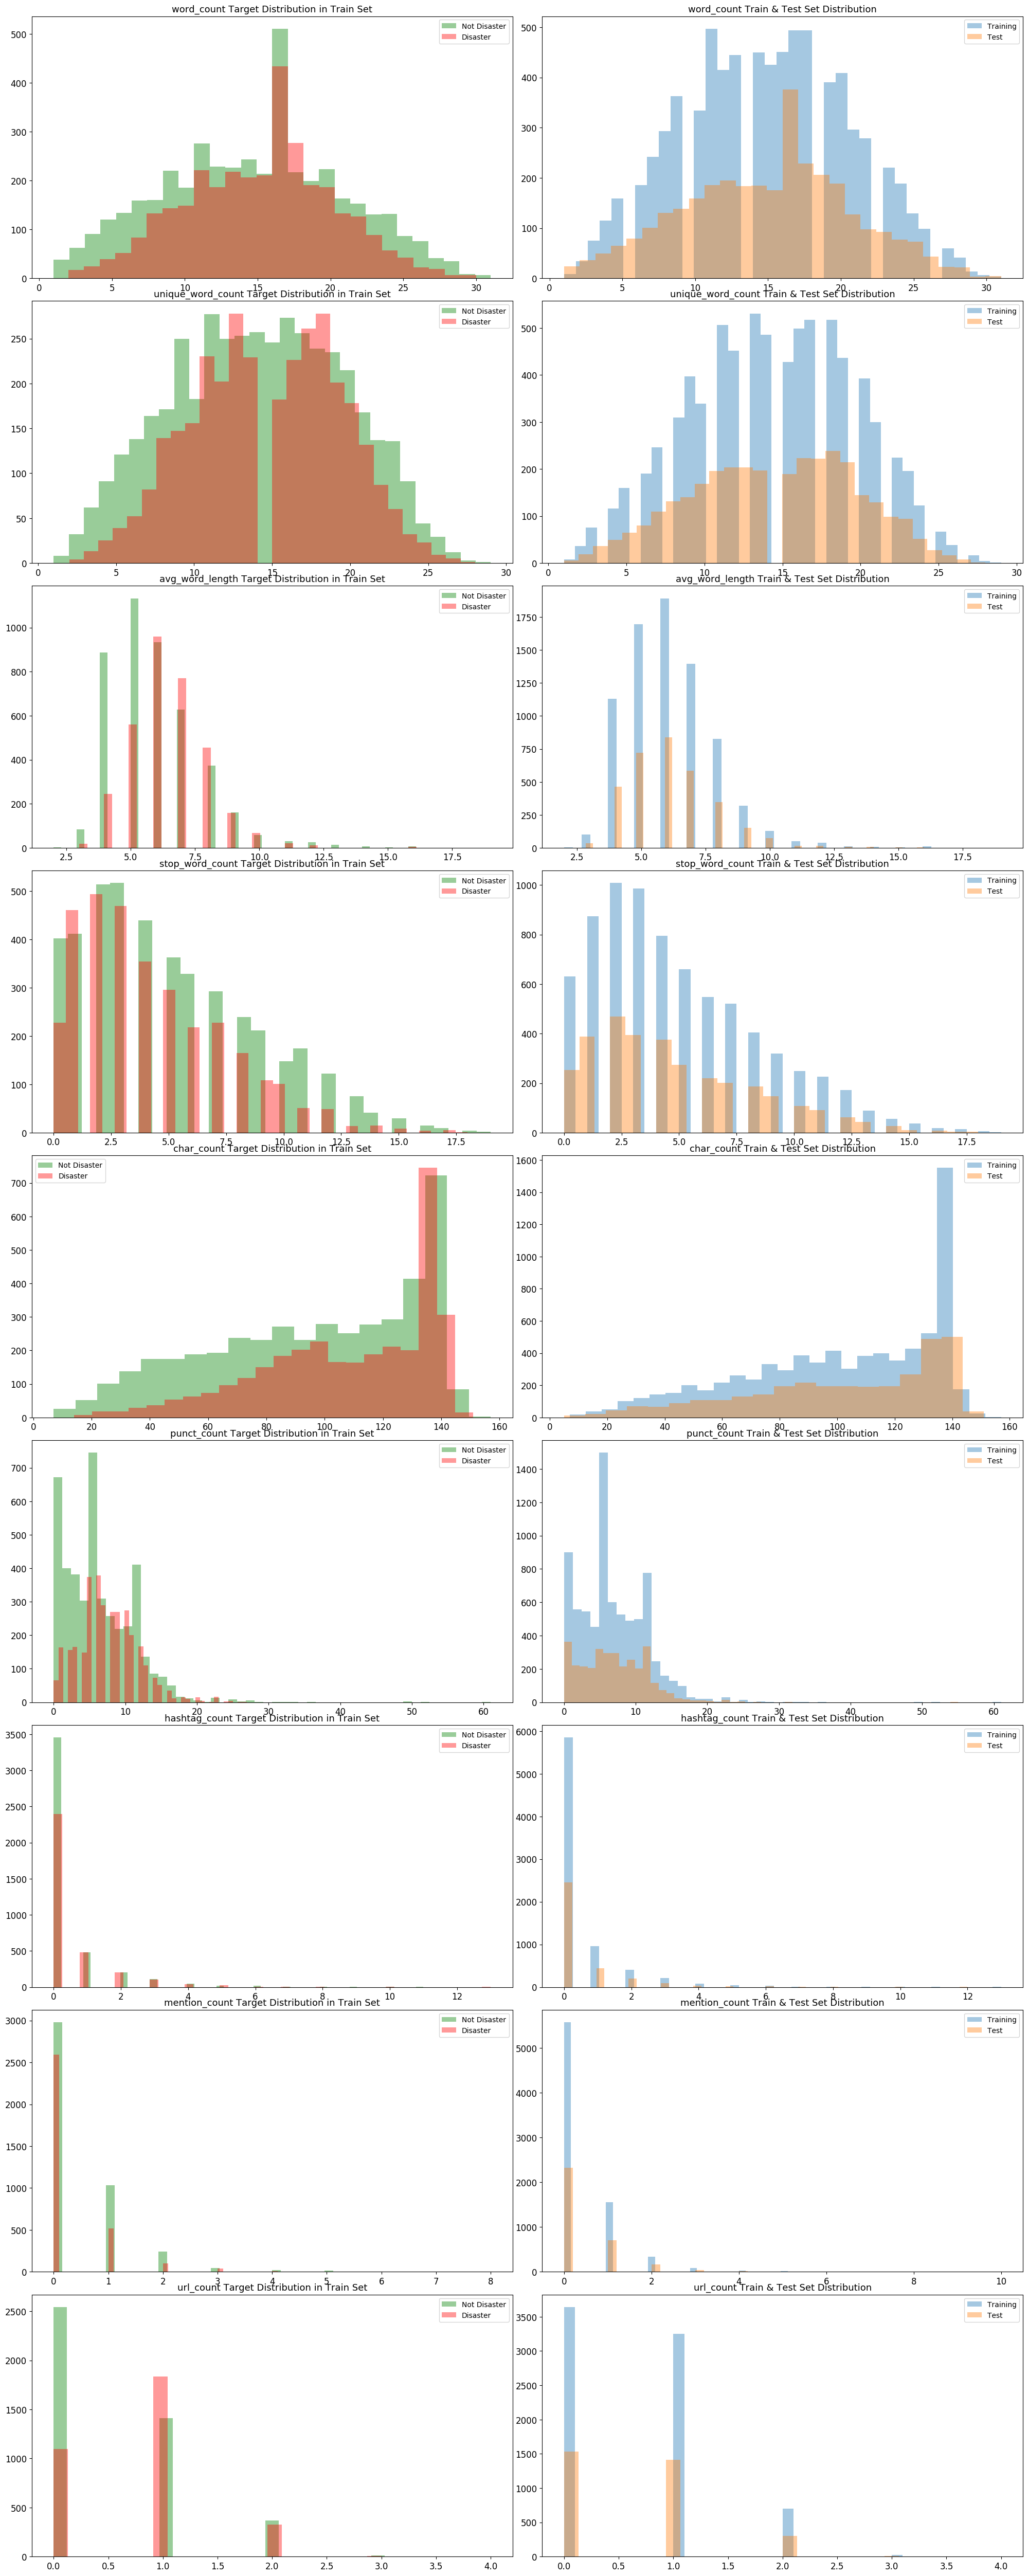

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=len(meta_features), figsize=(20, 50), dpi=100)
plt.tight_layout()

for i, feature in enumerate(meta_features):
    sns.distplot(train.loc[~disaster][feature],kde=False, label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[disaster][feature],kde=False, label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train[feature],kde=False, label='Training', ax=axes[i][1])
    sns.distplot(test[feature],kde=False, label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Train Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Train & Test Set Distribution', fontsize=13)

plt.show()

As observed from the new meta features we have created previously, all this features have similar distribuitions as we have seen in our first analysis right in the begining of this notebook, therefore this is closer to proving our "theory" that the training and test sets are taken from the same sample.

We have seen that most of the features have information about the target, but there are some like:** url_count, hasthag_count** and **mention_count** that do not provide insightful information in regards to the target, as seen from the graphs above.

But on the other hand, insightful meta features such as **word_count, stop_word_count, avg_word_density, char_count** and **punct_count** have different distribuitions for **disaster** and **non-disaster tweets**.

## 5) Target & N-grams Analysis

For this section we are going to analyse the 'target' column, which tells whether we have a **disaster** tweet (==1) or a **non-disaster** tweet (==0). 

We also have decided to preform an N-grams analysis where we will be simply making combination of adjacent letter or words of length n that we can find in a tweet. But for sake of simplicity and since tweets can't have lot's of characters in them we decided to preform an unigram, bigram and trigram analysis.


### 5.1) Target variable analysis

As we can see from the graphs below we have:
- **57%** for **non-disaster** tweets
- **43%** for **disaster** tweets.

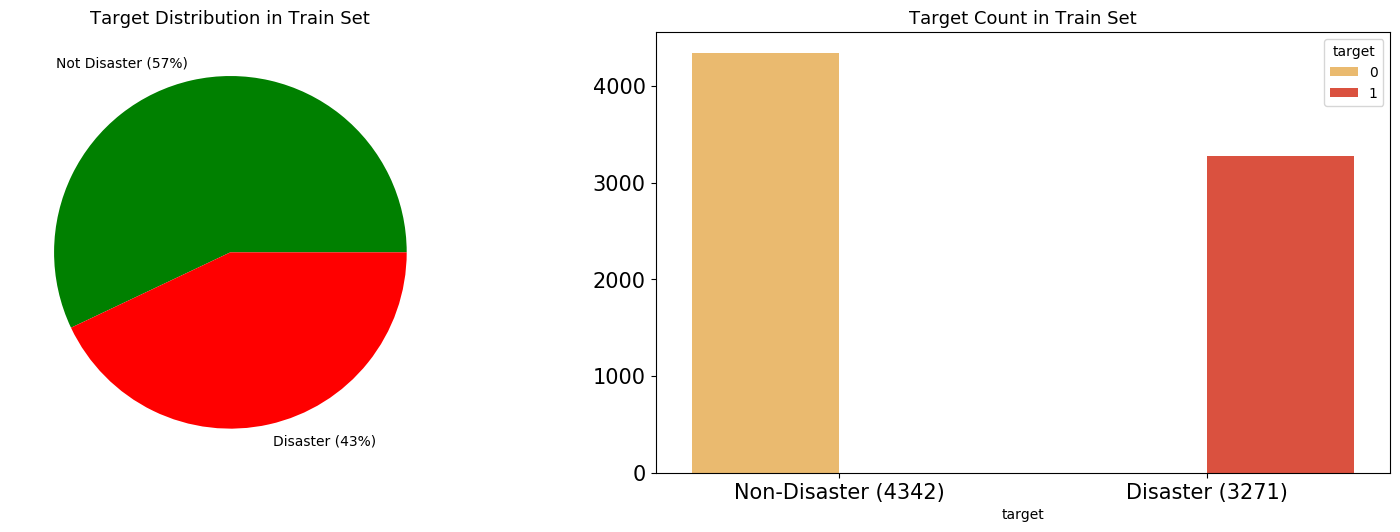

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie',colors= 'green', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x= train['target'], hue= train['target'], ax=axes[1], palette= "YlOrRd")

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Non-Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Train Set', fontsize=13)
axes[1].set_title('Target Count in Train Set', fontsize=13)

plt.show()

### 5.2) N-gram analysis
Before jumping into creating our n-grams, we created a function that will allow us to generator n-grams for any number that we wish for.

In [46]:
def ngrams_generator(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

#### 5.2.1) Unigrams

As seen from the graphical representation of our unigrams, we can clearly observe that the "most common" unigrams exist for both cases, disaster and non-disaster. As we can see the most common cases are punctuations, stop words or numbers, this would be the most expected output. Therefore on the next section for "Text pre-processing & Cleaning" we will be cleaining all of this before jumping into modelling since they don't add relevant information to our target variable.

The most common unigrams found in **disaster** tweets are the words that directly describe an accident/disaster, therefore it is very hard to use some of this words in other contexts besides the ones relatede to disasters.

In regards to **non-disaster** unigrams we found out that the most common ones are verbs, but we will further prove this later. Which makes sense to use because most of this senteces have an "informal" phrasing as they come from individual and not from news agencies.

In [47]:
disaster_unigrams = defaultdict(int)
non_disaster_unigrams = defaultdict(int)

for tweet in train[disaster]['text']:
    for word in ngrams_generator(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~disaster]['text']:
    for word in ngrams_generator(tweet):
        non_disaster_unigrams[word] += 1
        
disaster_unigrams_DF = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
non_disaster_unigrams_DF = pd.DataFrame(sorted(non_disaster_unigrams.items(), key=lambda x: x[1])[::-1])

##### Unigram graph

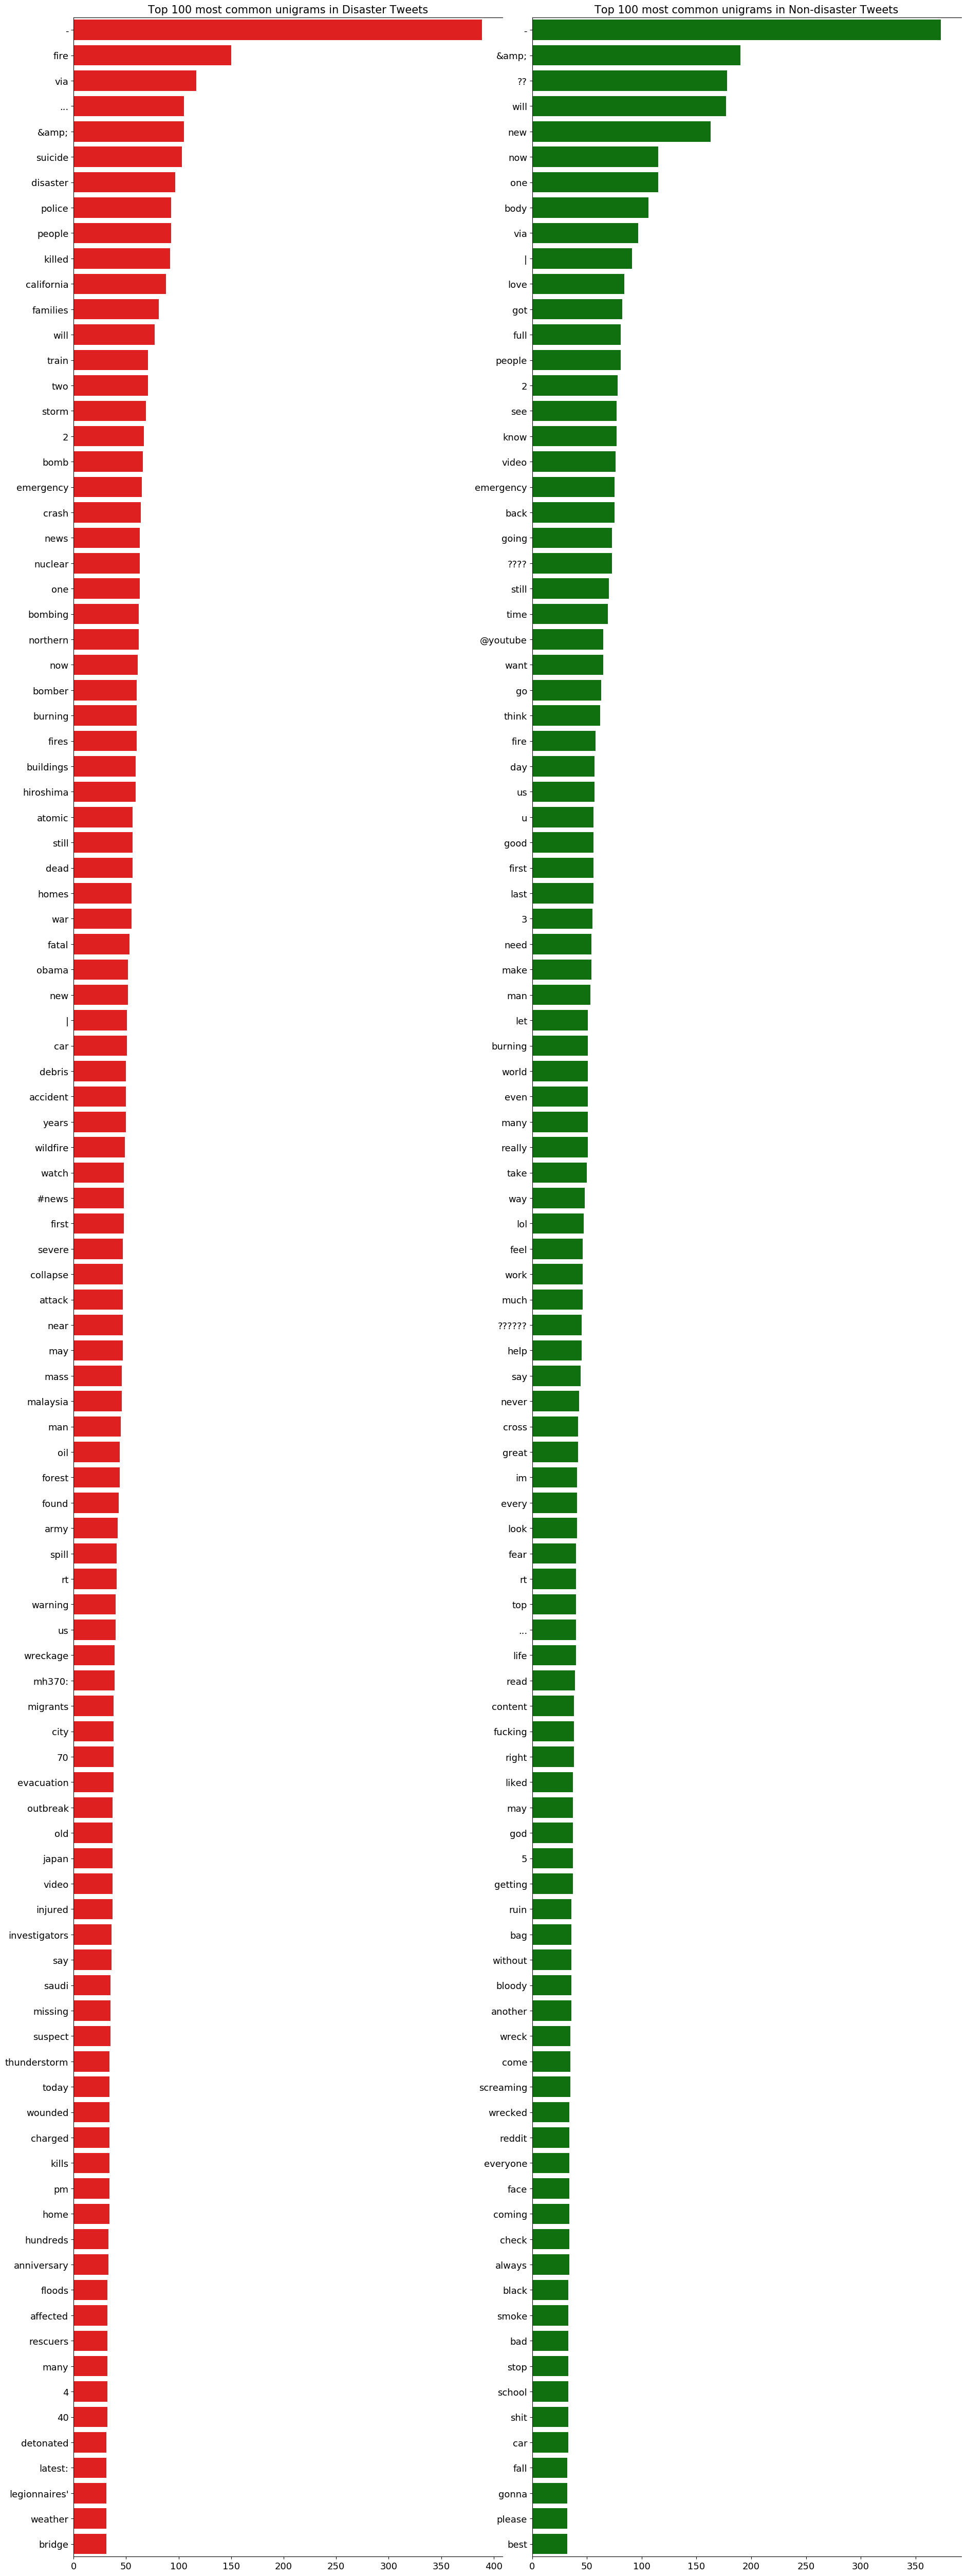

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y= disaster_unigrams_DF[0].values[:N], x= disaster_unigrams_DF[1].values[:N], ax=axes[0], color='red')
sns.barplot(y= non_disaster_unigrams_DF[0].values[:N], x= non_disaster_unigrams_DF[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

#### 5.2.2) Bigrams
As we would expect, the more we increase our n-grams the harder it will be to match between disaster and non-disaster, so as seen from the graph below there are **no common** bigrams that exist in both cases, this happens because the context is getting clearer.

Adding more words now, creates more context, therefore we can see that in **disaster** tweets we can understand that this bigrams are giving **more information** about the disaster when comparaed to unigrams.

In regards to **non-disaster** tweets as we can see most of them are either about **YouTube** or **Reddit**, plus they contain a lot of punctuation.

So as stated previously we will need to clean puntuation from our model analysis.

In [49]:
disaster_bigrams = defaultdict(int)
non_disaster_bigrams = defaultdict(int)

for tweet in train[disaster]['text']:
    for word in ngrams_generator(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~disaster]['text']:
    for word in ngrams_generator(tweet, n_gram=2):
        non_disaster_bigrams[word] += 1
        
disaster_bigrams_DF = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
non_disaster_bigrams_DF = pd.DataFrame(sorted(non_disaster_bigrams.items(), key=lambda x: x[1])[::-1])

##### Bigram graph

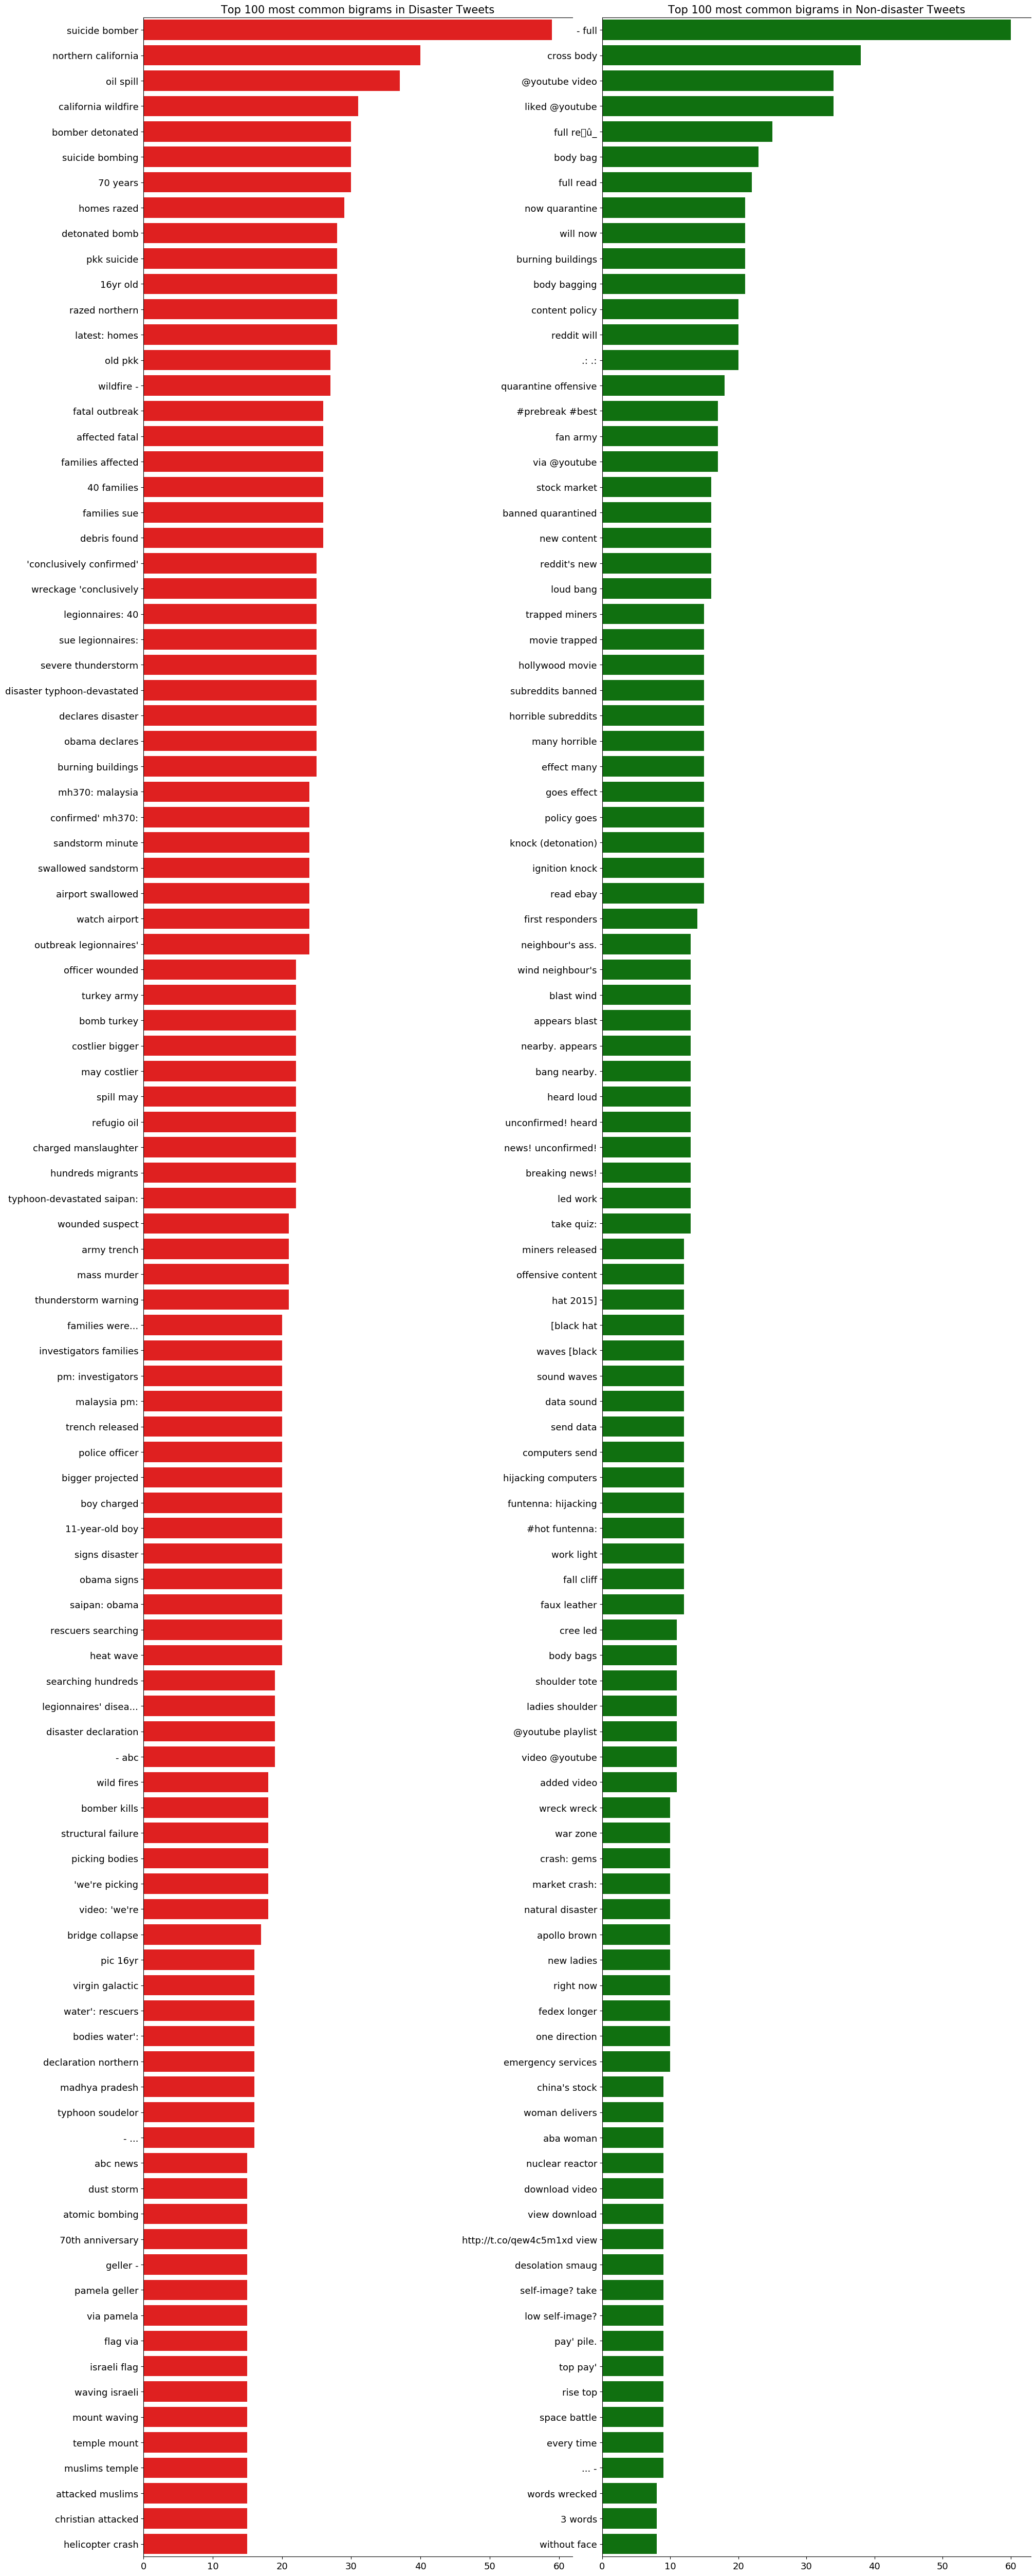

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=disaster_bigrams_DF[0].values[:N], x=disaster_bigrams_DF[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=non_disaster_bigrams_DF[0].values[:N], x=non_disaster_bigrams_DF[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

#### 5.2.3) Trigrams
As we would expect also, as in bigrams, it's becoming harder to match between them but it is becoming **clearer** to us the difference between disaster and non-disaster tweets.

Adding more words now, creates more context, therefore we can see that in **disaster** tweets, as stated previously, so the trigrams that we are seeing now are very similar to the bigrams we observed before, but now they give even **more information** about the disaster when comparaed to bigrams.

In regards to **non-disaster** tweets as we can see most of them are similar to the ones found in the bigrams. Once more we can observe more punctuation.


In [51]:
disaster_trigrams = defaultdict(int)
non_disaster_trigrams = defaultdict(int)

for tweet in train[disaster]['text']:
    for word in ngrams_generator(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in train[~disaster]['text']:
    for word in ngrams_generator(tweet, n_gram=3):
        non_disaster_trigrams[word] += 1
        
disaster_trigrams_DF = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
non_disaster_trigrams_DF = pd.DataFrame(sorted(non_disaster_trigrams.items(), key=lambda x: x[1])[::-1])

##### Trigram graph

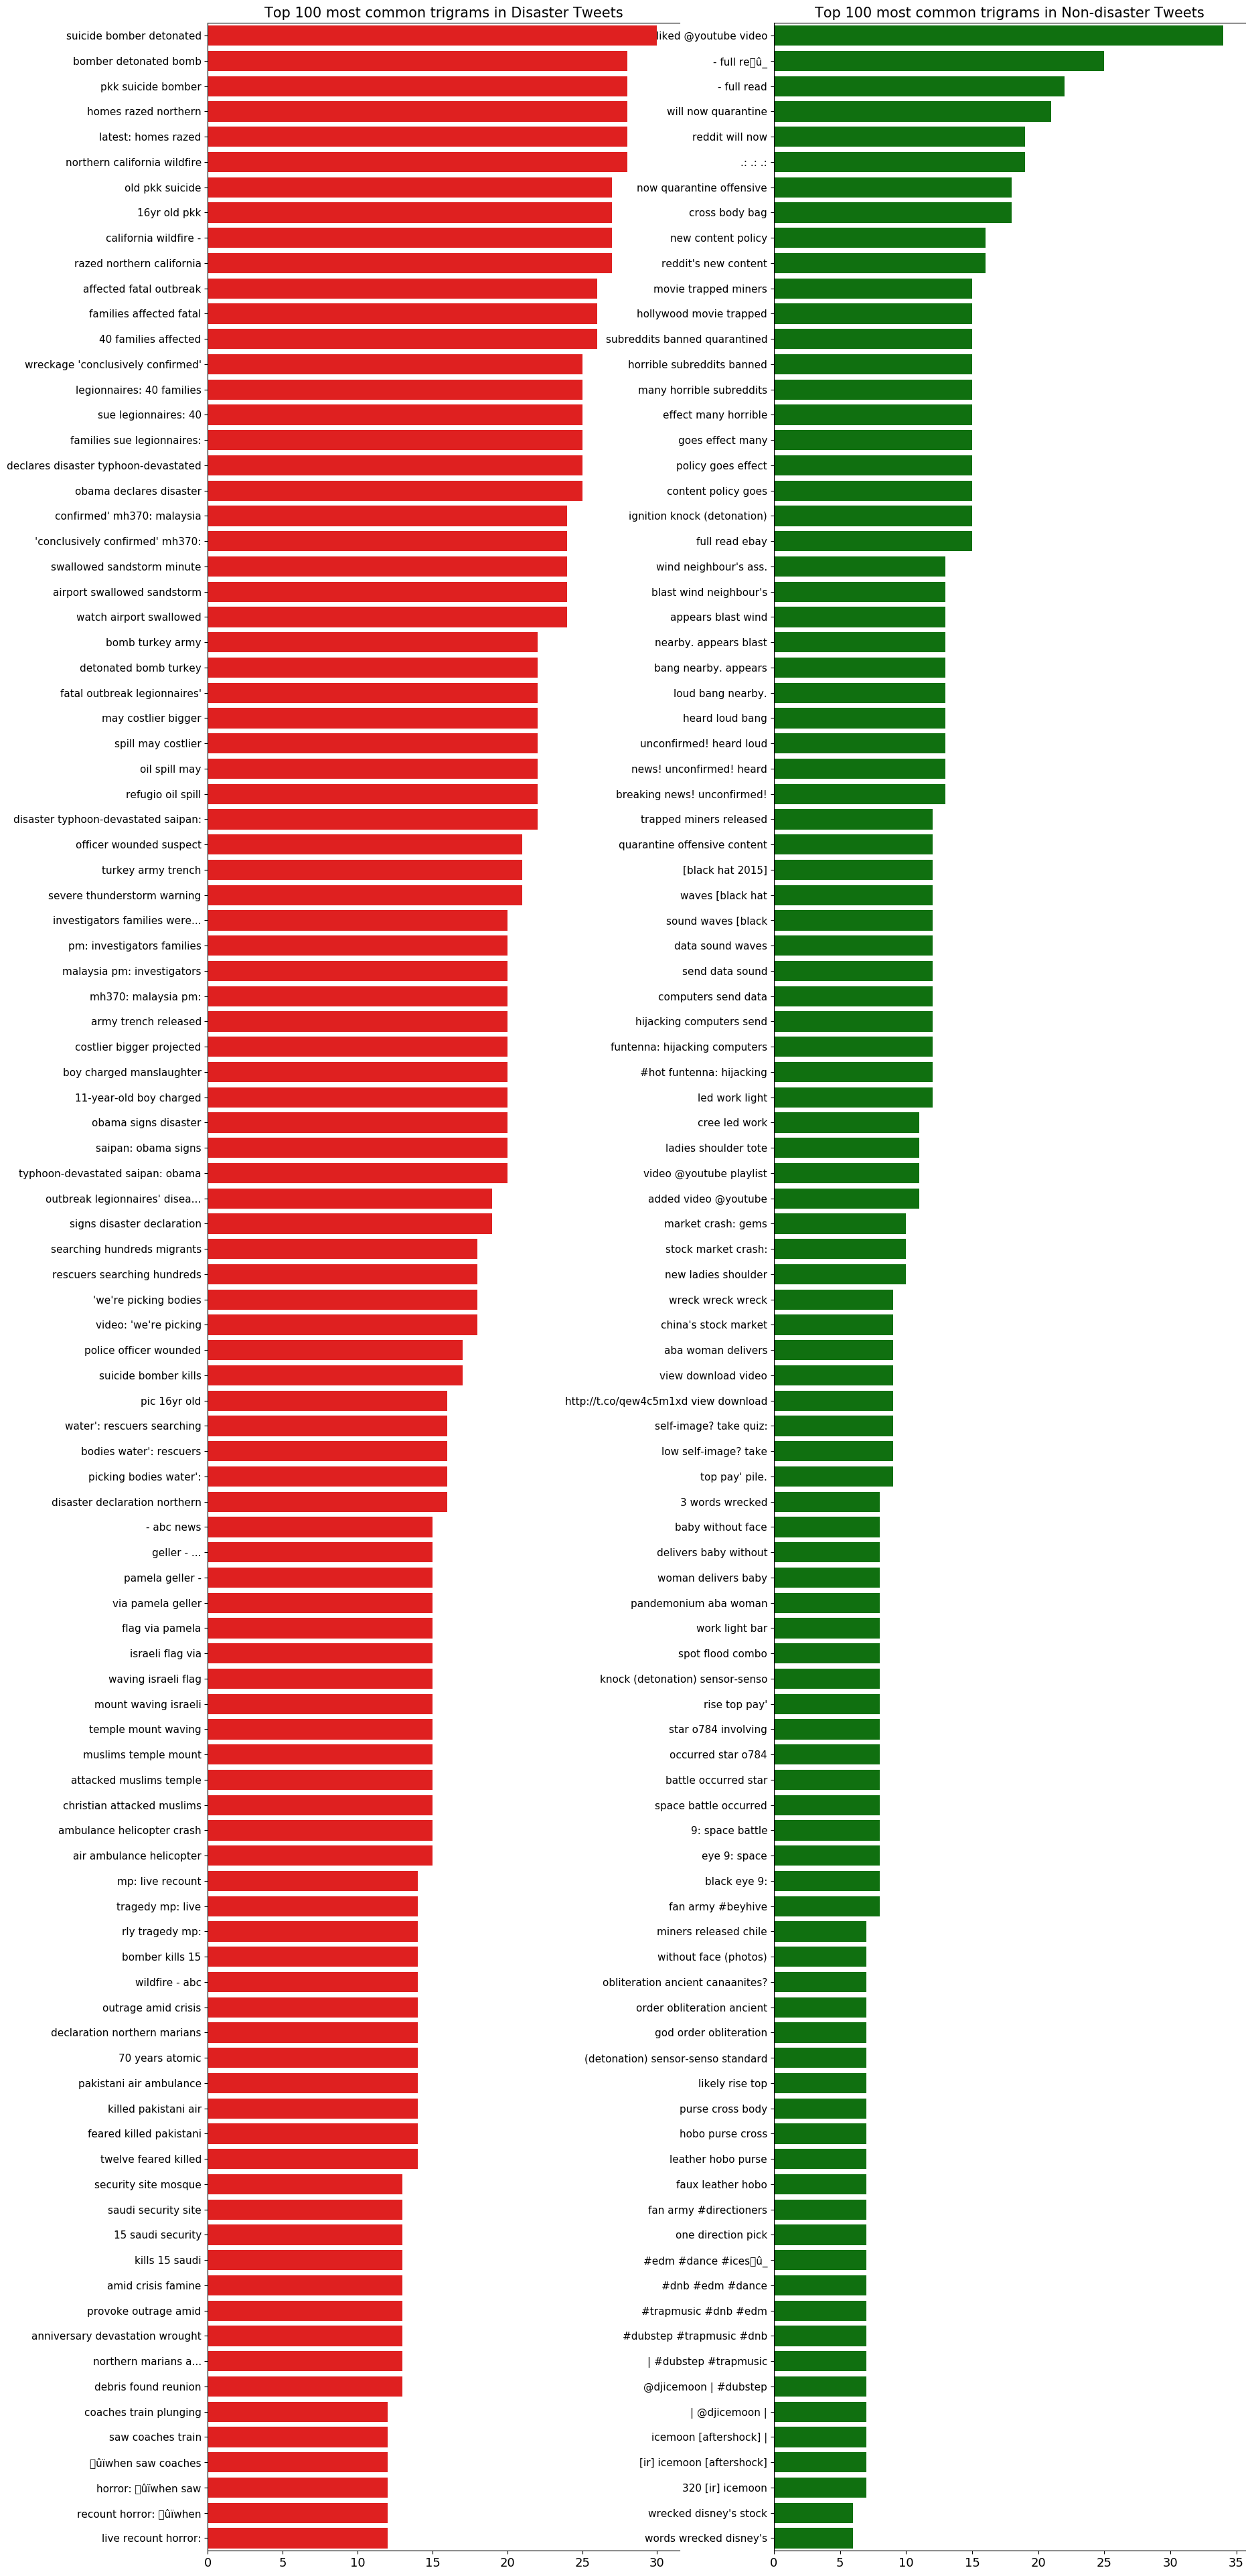

In [52]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=disaster_trigrams_DF[0].values[:N], x=disaster_trigrams_DF[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=non_disaster_trigrams_DF[0].values[:N], x=non_disaster_trigrams_DF[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## 6) Text pre-processing & Cleaning

As we were able to understand thoughtout the last section, most particularly from the **n-gram analysis** we need to preform some text pre-processing & cleaning. Tweets as we have mentioned before for this case, can be written either by news agencies or individuals, therefore there is are a variety of possible combinations of words and styles of writting that we need to take into consideration, therefore we will need to clean all of this tweets. But since cleaning every single tweet one by one is time consuming, we need to take a more general approach in this section in order to solve this. So we have decided to preform the following text pre-processing and cleaning techniques on our tweets:

- **Converting to Lower Case**
- **Removing punctuations**
- **Removing emoji's**
- **Removing stopwords**
- **Removing URL's & HTML**
- **Character entity reference transformation** 
- **Spelling Correction** 
- **Contractions**
- **Correction on typos, abbreviations & slang**
- **"POS Tagging"** 


### 6.1) Converting to Lower Case

train['lower_case'] = train['text'].apply(lambda x: x.lower()) 

### 6.2) Removing punctuations
As stated previously in our n-gram analysis we have concluded that we had a lot of punctuation characters in our tweets therefore we decided to eleminate them from our analysis because they don't help define whether we have a disaster or non-disaster tweet.

def punctuation_removal(t):
    return ''.join(x for x in t if x not in punctuation)

In [53]:
def punctuation_removal(t):
    punct = str.maketrans('', '', string.punctuation)
    return t.translate(punct)

### 6.3) Removing emoji's
Similar to punctuation we have decided to removve emojis from our analysis because they don't help us understand our target variable.


In [54]:
def emoji_removal(text):
    emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji.sub(r'', text)

### 6.4) Removing stopwords
For analysis like the one we are undergoing in this assignment, text classification, where we need to classify text into disaster and non-disaster tweets, stopwords like: "the, "a," "and," "but," "how," "or," and "what, need to be removed because we need to focus to words that define what are we are looking for.

stopword = stopwords.words('english')
def stopwords_removal(x):
    words = nltk.word_tokenize(x)
    remove = [word for word in words if word not in stopword]
    return ','.join(remove)

### 6.5) Removing URL's & HTML
Website characters that are included in URL's and HTML should be removed because they don't add any meaning to the text.  

In [55]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    url = re.compile(r"pic.twitter.com\S+")
    return url.sub(r'',text)

In [56]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

### 6.6) Character entity reference transformation
This is mainly a HTML character entity reference transformations, this chracter entities are a special set of characters, which website browsers display as a symbol or special characters, which each symbol has an entity reference code. But for the sake of this assignment when trying to apply this feature to our model, it didn't add any value, therefore we didn't use it for our final model.

def character_entity_ref1(text):
    char_ent_ref =re.compile(r'&gt;')
    return char_ent_ref.sub(r'>',text)

def character_entity_ref2(text):
    char_ent_ref =re.compile(r'&lt;')
    return char_ent_ref.sub(r'<',text)

def character_entity_ref3(text):
    char_ent_ref =re.compile(r'&lt;')
    return char_ent_ref.sub(r'&',text)

### 6.7) Spelling Correction
We have created a formula that uses a library named 'spellcheck' which corrects words that are misspelled in the english language. Computationally this is the formula that takes the longest to process in our dataset but with the help of this formula we were able to observe major accuracy improvements on the test set.

spelling = SpellChecker()
def correct_spellings(text):
    tweet_correction = []
    misspelled_words = spelling.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            tweet_correction.append(spelling.correction(word))
        else:
            tweet_correction.append(word)
    return " ".join(tweet_correction)

train['text'] = train['text'].apply(lambda x : correct_spellings(x))

### 6.8) Contractions
As we know, contractions are combinations of words which are shortened by dropping lettares and replacing in most cases with an apostrophe.

We decided to include this text pre-processing feature in our models because of two main reasons, firstly because computers don't understand what are contractions, they consider words like he's and he is to be two different things, when in fact they aren't. The other reason why we decided to use this tool was because in the long term having contractions in a dataset increases demensionality, therefore it makes computation expensive.

**Note:** formula inspiration found sourced in the end of this notebook. 

def contractions(text):
    
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)  
    
    return text

### 6.9) Correction on typos, abbreviations & slang

As spelling corrections, will correct most of our spelling mistakes, this formula belowe corrects specific cases applied to the dataset, where we are going to correct typos, abbrevviations and some slang used. But since this doesn't add any relevant accuracy to our model scores we won't be using for our final model.


**Note:** formula inspiration found sourced in the end of this notebook. 

def typos_correction (typos):
   
    typos = re.sub(r"w/e", "whatever", typos)
    typos = re.sub(r"w/", "with", typos)
    typos = re.sub(r"USAgov", "USA government", typos)
    typos = re.sub(r"recentlu", "recently", typos)
    typos = re.sub(r"Ph0tos", "Photos", typos)
    typos = re.sub(r"amirite", "am I right", typos)
    typos = re.sub(r"exp0sed", "exposed", typos)
    typos = re.sub(r"<3", "love", typos)
    typos = re.sub(r"amageddon", "armageddon", typos)
    typos = re.sub(r"Trfc", "Traffic", typos)
    typos = re.sub(r"8/5/2015", "2015-08-05", typos)
    typos = re.sub(r"WindStorm", "Wind Storm", typos)
    typos = re.sub(r"8/6/2015", "2015-08-06", typos)
    typos = re.sub(r"10:38PM", "10:38 PM", typos)
    typos = re.sub(r"10:30pm", "10:30 PM", typos)
    typos = re.sub(r"16yr", "16 year", typos)
    typos = re.sub(r"lmao", "laughing my ass off", typos)   
    typos = re.sub(r"TRAUMATISED", "traumatized", typos)
    
    return typos

### 6.10) Text Cleaning

In [57]:
def cleaning(tweet): 
    tweet = remove_URL(tweet)
    tweet = remove_html(tweet)
    tweet = emoji_removal(tweet)
    tweet = punctuation_removal(tweet)
    return tweet

In [58]:
train['text'] = train['text'].apply(lambda x : cleaning(x))
test['text'] = test['text'].apply(lambda x : cleaning(x))

## 7) Tokenization

### In this portion we will be tokenizing our 'text' feature.

In order to make sure we have made the correct decision in terms of which tokenizer to be used, we decided to take a look at the different tokenizers we have. The first step was to apply all the tokenizers onto our 'text' feature and we chose to only compare five: word_tokenizer, TweetTokenizer, WordPunctTokenizer, Regexp Word Tokenizer and, Regexp Space Tokenizer. 

In [59]:
## Making a copy of the dataframe in order not to manipluate the original csv file
train_df2 = train.copy()
test_df2 = test.copy()

##### Word Tokenizer
 
Is known to be one of the most popular tokenizers and splits a given sentence into single words separated by both punctuation and spaces. 

In [60]:
## Applying a word_tokenizer to our 'text' feature 

train_df2['word_tokenizer'] = train_df2['text'].apply(nltk.word_tokenize)
test_df2['word_tokenizer'] = test_df2['text'].apply(nltk.word_tokenize)

##### Tweet Tokenizer
This specific tokenizer, from its name, takes into account the syntax and formation of tweets. What we  mean by this is that the tweet tokenizer, for example, will not split hashtags and words separately but in fact keep them together as a single token considering it changes the meaning. 

In [61]:
## Applying a TweetTokenizer to our 'text' feature 
tweet_tokenizer = TweetTokenizer()

train_df2['tweet_tokenizer'] = train_df2['text'].apply(tweet_tokenizer.tokenize)
test_df2['tweet_tokenizer'] = test_df2['text'].apply(tweet_tokenizer.tokenize)

##### WordPunct Tokenizer
From its name we can see that this tokenizer separates all punctuation into separate tokens. 

In [62]:
## Applying a WordPunctTokenizer to our 'text' feature 
word_punct_tokenizer = WordPunctTokenizer()

train_df2['word_punct_tokenizer'] = train_df2['text'].apply(word_punct_tokenizer.tokenize)
test_df2['word_punct_tokenizer'] = test_df2['text'].apply(word_punct_tokenizer.tokenize)

##### Regex Tokenizer
In the RegexpTokenizer we have [\w']+ which is a regex function which matches a word character, alphanumeric. 

In [63]:
## Using the Regex tokenizer and separating the 'text' feature by words 
regex_word_tokenizer = RegexpTokenizer("[\w']+")

train_df2['regex_word_tokenizer'] = train_df2['text'].apply(regex_word_tokenizer.tokenize)
test_df2['regex_word_tokenizer'] = test_df2['text'].apply(regex_word_tokenizer.tokenize)

**Regexp Space Tokenizer:** in the RegexpTokenizer we have '\s+' and gaps=True. What this means is that we are checking for gaps and separating by available spaces only. 

In [64]:
## Using the Regex tokenizer once more; however, this time we are separating the 'text' feature by spaces
regex_space_tokenizer = RegexpTokenizer("\s+", gaps=True)

train_df2['regex_space_tokenizer'] = train_df2['text'].apply(regex_space_tokenizer.tokenize)
test_df2['regex_space_tokenizer'] = test_df2['text'].apply(regex_space_tokenizer.tokenize)

In [65]:
## Creating a new dataframe for just the tokenizers in order to make a more informed decision in 
## regards to the best possible tokenizer for our dataset

tokenizers_df = train_df2[['word_tokenizer', 'tweet_tokenizer', 'word_punct_tokenizer', 'regex_word_tokenizer', 'regex_space_tokenizer']].copy()

tokenizers_df.head(20)

,word_tokenizer,tweet_tokenizer,word_punct_tokenizer,regex_word_tokenizer,regex_space_tokenizer
0,"[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth...","[Our, Deeds, are, the, Reason, of, this, earth..."
1,"[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]","[Forest, fire, near, La, Ronge, Sask, Canada]"
2,"[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place...","[All, residents, asked, to, shelter, in, place..."
3,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,"[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala...","[Just, got, sent, this, photo, from, Ruby, Ala..."
5,"[RockyFire, Update, California, Hwy, 20, close...","[RockyFire, Update, California, Hwy, 20, close...","[RockyFire, Update, California, Hwy, 20, close...","[RockyFire, Update, California, Hwy, 20, close...","[RockyFire, Update, California, Hwy, 20, close..."
6,"[flood, disaster, Heavy, rain, causes, flash, ...","[flood, disaster, Heavy, rain, causes, flash, ...","[flood, disaster, Heavy, rain, causes, flash, ...","[flood, disaster, Heavy, rain, causes, flash, ...","[flood, disaster, Heavy, rain, causes, flash, ..."
7,"[Im, on, top, of, the, hill, and, I, can, see,...","[Im, on, top, of, the, hill, and, I, can, see,...","[Im, on, top, of, the, hill, and, I, can, see,...","[Im, on, top, of, the, hill, and, I, can, see,...","[Im, on, top, of, the, hill, and, I, can, see,..."
8,"[Theres, an, emergency, evacuation, happening,...","[Theres, an, emergency, evacuation, happening,...","[Theres, an, emergency, evacuation, happening,...","[Theres, an, emergency, evacuation, happening,...","[Theres, an, emergency, evacuation, happening,..."
9,"[Im, afraid, that, the, tornado, is, coming, t...","[Im, afraid, that, the, tornado, is, coming, t...","[Im, afraid, that, the, tornado, is, coming, t...","[Im, afraid, that, the, tornado, is, coming, t...","[Im, afraid, that, the, tornado, is, coming, t..."


After applying all the above tokenizer to our 'text' feature, we decided to form a new dataframe, named tokenizers_df, in order to be able to visually compare the effect of the above mentioned tokenizers. When looking more in depth at the tokenizer, we can see that all of them split up the hashtag from the word into separate tokens except for the tweet tokenizer. Moreover, the Regexp word tokenizer actually removed the hashtags all together. Comparing the displayed tokenizers allowed us to come to the best decision for our 'text' feature. In conclusion, we decided to go with the tweet tokenizer as it could best represent our specific goals.  

## 8) Lemmatization
### In this section we will be performing lemmatization with POS tagging.

Lemmatization changes the word to its original form; however, it takes into account the context of the sentence and not just the word, unlike stemming. We are using the WordNetLemmatizer with NLTK as it has a large database of the English language as well as having a good view of the relationship between words and their true meaning. In addition to this, the WordNetLemmatizer is the most common and most popular lemmatizer being used.

Sometimes, the lemmatizer still does not return the correct base of the word. In order to correct this, we pair the lemmatizer with a POS tagger as a second argument to make sure this mistake is avoided. We do this by finding out the POS tag of each word, mapping it as the correct input to which the WordNetLemmatizer will accept and finally passing it as the second argument to the lemmatizer. 

We first create a function get_wordnet_pos that maps the input that WordNetLemmatizer accepts followed by passing the pos function created to map everything correctly and finally applying the this function to our 'text' feature providing us with our wanted results.

In [66]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [67]:
lemmatizer = WordNetLemmatizer()

def pos(x):
    words = nltk.word_tokenize(x)
    lemma_word = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return ' '.join(lemma_word)

train_df2['lemmatization1'] = train_df2.text.apply(pos)
test_df2['lemmatization1'] = test_df2.text.apply(pos)

## 9) Modelling

In [68]:
count_vectorizer = CountVectorizer(ngram_range=(1,2))

X_train = count_vectorizer.fit_transform(train['text'])

X_test = count_vectorizer.transform(test['text'])

#### Split data into learning and validation sets

Our team has decided to preform the traditional split: 80% for training set and 20% for testing set.

In [69]:
target = train['target']

X_learn, X_valid, y_learn, y_valid = train_test_split(X_train,target, test_size=0.2, random_state=40)

## 9.1) Training Models

#### Collection of all trained models and results

In [70]:
models = {}

In [71]:
def run_model(ID, clf, X_train, X_test, y_train, y_test):  
    # Train model
    clf.fit(X_train, y_train)
    
    # Make predictions
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    # Score predictions
    train_score = accuracy_score(y_train, train_predictions)
    test_score = accuracy_score(y_test, test_predictions)
    
    confusion_mtx = confusion_matrix(y_test, test_predictions)
    
    # Save model and results to dictionary
    models[ID] = {"clf": clf,
                  "test_score": test_score, 
                  "train_score": train_score,
                  "confusion_mtx": confusion_mtx,
                  "test_predictions": test_predictions
                 }
    print("Test Score: {}".format(test_score))
    print("Train Score: {}".format(train_score))
    print("Confusion Matrix:\n", confusion_mtx)

### 9.1.1) Naive Bayes

The Naive Bayes model, which is based on Bayes's Theorem is a good modelling technique for text classification problems and widely used in NLP because it helps us calculate the conditional probability of two events, based on the probability of ocurrence of an individual event, which is the case for this particular assignment.

In [72]:
mdl = MultinomialNB()
run_model('Naive_Bayes',mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.7957977675640184
Train Score: 0.9689655172413794
Confusion Matrix:
 [[714 138]
 [173 498]]


### 9.1.2) Stochastic Gradient Descent

For this model we used an TF-IDF vectorizer with a Stochastic Gradient Descent classifier, this modelling classifier is an iterative method that is used to optimize a function with smoothness properties. Basically, the gradient of loss is estiamted in each sample at a time, while the model is being updated during the entire process with a decreased learning rate.This type of model, specially in large datasets reduces computational "burden" because it is able to reach faster iteration, but with a small trade-off, we will have a lower convergence rate.

In [73]:
count_vectorizer = TfidfVectorizer(ngram_range=(1,2))

X_train = count_vectorizer.fit_transform(train['text'])

X_test = count_vectorizer.transform(test['text'])

target = train['target']

X_learn, X_valid, y_learn, y_valid = train_test_split(X_train,target, test_size=0.2, random_state=40)

mdl = SGDClassifier()
run_model('TF-IDF',mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.8056467498358503
Train Score: 0.9844006568144499
Confusion Matrix:
 [[774  78]
 [218 453]]


### 9.1.3) Logistic Regression

This modelling tehcnique is used to analyse datasets in which there are one or several  independent variables that can help us determine an outcome. The outcome is usually measured with a dichotomous variable, in other words binary, in which there are only two possible outcomes possible.

This modelling tehcnique is used to analyse datasets in which there are one or several  independent variables that can help us determine an outcome. The outcome is usually measured with a dichotomous variable, in other words binary, in which there are only two possible outcomes possible.

In [74]:
## Logistic - Tfidf
count_vectorizer = TfidfVectorizer(min_df=2, max_df=0.2)
X_train = count_vectorizer.fit_transform(train['text'])

#We call transform on the test data to create bag of words vectors using the same dictionary

X_test = count_vectorizer.transform(test['text'])

target = train['target']
X_learn, X_valid, y_learn, y_valid = train_test_split(X_train,target, test_size=0.2, random_state=40)

#Initializing our class and calling fit without training data
mdl = LogisticRegression(C=1,max_iter=1000,penalty='l2')


run_model('LOG',mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.8108995403808273
Train Score: 0.8781609195402299
Confusion Matrix:
 [[771  81]
 [207 464]]


In [75]:
mdl = LogisticRegression(C=100, multi_class='auto', random_state=40)
run_model('LogisticRegression', mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.7688772160210111
Train Score: 0.9827586206896551
Confusion Matrix:
 [[708 144]
 [208 463]]


#### Logistic regression with lemmatization

In [94]:
## Logistic Regression - Count Vectorizer - ngram
count_vectorizer = CountVectorizer(min_df=2, max_df=0.5,ngram_range=(1,2))
count_train = count_vectorizer.fit_transform(train_df2['lemmatization1'])

#We call transform on the test data to create bag of words vectors using the same dictionary

count_test = count_vectorizer.transform(test_df2['lemmatization1'])

target = train_df2['target']
X_learn, X_valid, y_learn, y_valid = train_test_split(X_train,target, test_size=0.2, random_state=40)

#Initializing our class and calling fit without training data
mdl = LogisticRegression()


#Evaluating model performance
run_model('LOG with Lemmatization',mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.8108995403808273
Train Score: 0.8781609195402299
Confusion Matrix:
 [[771  81]
 [207 464]]


### 9.1.4) Decision Trees
After working with a Decision-Tree as our baseline model, without dropping any columns, outliers and doing any major feature engineering we will be try and run a decision-tree model with all the cleaning we have done.

**What are Decision-Trees's?**

A decision-tree model is a decision support tool, as the name suggests, that uses a tree-like model to make decisions, regarding a possible consequence. 

In [76]:
from sklearn.tree import DecisionTreeClassifier
mdl = DecisionTreeClassifier()
run_model('DecisionTreeClassifier', mdl, X_learn, X_valid, y_learn, y_valid)

Test Score: 0.7360472751149048
Train Score: 0.9862068965517241
Confusion Matrix:
 [[673 179]
 [223 448]]


### 9.1.5) Random Forest

This modelling  technique is a classification algorithm that consists of multiple decision trees. This model uses "bagging" and feature randomness when creating an individual tree to try and create an uncorrelated forestst of trees whose prediction is more accurate than individual trees. Random Forest algorithms increase the predictive power of algorithms and also helps prevent overfitting.

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

for d in range(10, 26, 5):
    print(d)
    mdl = RandomForestClassifier(max_depth=d, n_estimators=100, random_state=0)
    run_model('RandomForestClassifier_maxDepth{}'.format(d), mdl, X_learn, X_valid, y_learn, y_valid)

10
Test Score: 0.6487196323046619
Train Score: 0.6642036124794746
Confusion Matrix:
 [[848   4]
 [531 140]]
15
Test Score: 0.6841759684832567
Train Score: 0.7019704433497537
Confusion Matrix:
 [[846   6]
 [475 196]]
20
Test Score: 0.7078135259356533
Train Score: 0.7343185550082102
Confusion Matrix:
 [[844   8]
 [437 234]]
25
Test Score: 0.7196323046618516
Train Score: 0.7587848932676519
Confusion Matrix:
 [[840  12]
 [415 256]]


Tuning for **max_features:**


In [89]:
for f in range(1, 13, 2):
    print(f)
    mdl = RandomForestClassifier(max_depth=25, max_features=f, n_estimators=100, random_state=0)
    run_model('RandomForestClassifier_maxDepth20_maxFeatures{}'.format(f), mdl, X_learn, X_valid, y_learn, y_valid) 

1
Test Score: 0.5594221930400525
Train Score: 0.5730706075533661
Confusion Matrix:
 [[852   0]
 [671   0]]
3
Test Score: 0.5600787918581747
Train Score: 0.5737274220032841
Confusion Matrix:
 [[852   0]
 [670   1]]
5
Test Score: 0.5764937623112278
Train Score: 0.5980295566502463
Confusion Matrix:
 [[852   0]
 [645  26]]
7
Test Score: 0.6073539067629679
Train Score: 0.6284072249589491
Confusion Matrix:
 [[852   0]
 [598  73]]
9
Test Score: 0.6211424819435325
Train Score: 0.641543513957307
Confusion Matrix:
 [[852   0]
 [577  94]]
11
Test Score: 0.6303348653972423
Train Score: 0.6577996715927751
Confusion Matrix:
 [[852   0]
 [563 108]]


### 9.1.6) K-Nearest Neighbors
This method is considered to be a supervised statstical pattern recognition method. KNN usually and consistently achieves the highest performances, without a priori assumption. Therefore we will be appling this classifier, creating "neighbours" for each of our observations and map them before running our Random Forest Model.

In [79]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in [1,3,5]:
    print('n_neighbors:', n_neighbors)
    mdl = KNeighborsClassifier(n_neighbors = n_neighbors)
    run_model('KNN_n{}'.format(n_neighbors), mdl, X_learn, X_valid, y_learn, y_valid)

n_neighbors: 1
Test Score: 0.6940249507550886
Train Score: 0.9825944170771757
Confusion Matrix:
 [[811  41]
 [425 246]]
n_neighbors: 3
Test Score: 0.6671043992120814
Train Score: 0.7244663382594417
Confusion Matrix:
 [[844   8]
 [499 172]]
n_neighbors: 5
Test Score: 0.6474064346684176
Train Score: 0.6807881773399015
Confusion Matrix:
 [[847   5]
 [532 139]]


### 9.1.7) Support Vector Machine (SVM)

Support Vector Machine, or for short SVM is a linear classification and regression model that is used to solve linear and non-linear problems. This modelling technique usually works well in real-life pratical problems. The basic idea behind this algorithm is that it creates a line or as we call it a "hyperplane" which separates data into different classes.

In [80]:
from sklearn.svm import SVC
mdl = SVC()
run_model('SVC_rbf', mdl, X_learn, X_valid, y_learn, y_valid) 

Test Score: 0.8102429415627052
Train Score: 0.9568144499178982
Confusion Matrix:
 [[791  61]
 [228 443]]


In [81]:
mdl = SVC(kernel='poly', degree=1)
run_model('SVC_poly3', mdl, X_learn, X_valid, y_learn, y_valid) 

Test Score: 0.8017071569271176
Train Score: 0.9047619047619048
Confusion Matrix:
 [[757  95]
 [207 464]]


In [90]:
pd.DataFrame(models).transpose()[['test_score', 'train_score', 'clf']].sort_values('test_score', ascending=False)

,test_score,train_score,clf
LOG,0.8109,0.878161,"LogisticRegression(C=1, class_weight=None, dua..."
SVC_rbf,0.810243,0.956814,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
TF-IDF,0.805647,0.984401,"SGDClassifier(alpha=0.0001, average=False, cla..."
SVC_poly3,0.801707,0.904762,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
Naive_Bayes,0.795798,0.968966,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
LogisticRegression,0.768877,0.982759,"LogisticRegression(C=100, class_weight=None, d..."
DecisionTreeClassifier,0.736047,0.986207,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
RandomForestClassifier_maxDepth25,0.719632,0.758785,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
RandomForestClassifier_maxDepth20,0.707814,0.734319,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
KNN_n1,0.694025,0.982594,"KNeighborsClassifier(algorithm='auto', leaf_si..."


### 9.1.8) BERT (Bidirectional Encoder Representations from Transformers)

BERT is one of the most challenging models that we had to built up until this assignment during this Master's Degree due to it's degree of complexity. This model is known to be designed to pre-train bidirectional representations from unlabelled text by conditioning in the left and right context for all layers. This model is able to learn from both sides, left and right as mentioned side of token's context during the training phase.

We choose this model in particular because of it's bidirectionality, this chracterstics using a trained model such like this one allows us to truly understand the meaning of a language.


In [83]:
training_data = train.text.values
labels_data = train.target.values
sent_submission = test.text.values

On the code below we decided to load the 'Universal Sentence Encoder Large' layer which was developed by Google. Which choose this encoder because it is able to encode text into high dimensional vectors that we could use to solve problems such this one, text classification. This encoder developed by google was trained and optimized by them to analye "greater-than-word lenght texts" such as:
- Sentences
- Phrases
- Short paragraphs

This encoder was trained on a imense amount of different and varied data soures and with a variety of taskes with the sole aim of accommadintng in a dynamic way a variery of NLP tasks. This encoder also is trained with a Transformer encoder.

In [84]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embedding = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')

In terms of the model we used an Adam optimizer which is a "first-order gradient-based" optimization algorithm. Since we don't have a very powerful computer this optimizer, although it takes a bit of time to run (+15 minutes for the 20 epochs), it is a computationally efficient optimizer, due to it's low memory requirements and also this algorithm is extremely well suited for problems that are large in terms of data and parameters, which in our case we have a lot of words to analyse. 

In [85]:
def bert_model(embedding):
    build_model = Sequential([
        layers.Input(shape=[], dtype=tf.string),
        embedding,
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    build_model.compile(optimizer = "adam", loss='binary_crossentropy', metrics=['accuracy'])
    
    return build_model

In [86]:
model = bert_model(embedding)

To save this model we use the standard required file format, HDF5 or HF file (from what we learned in other examples), this file is basically saved into an Hierarchical Data format, which allows to easily store the weights and model all the configurations of this BERT model in a single file.

For our model we decided to make 32 samples to be processes before the model is updated (batch_size), we also decided to run 20 complete passes through the training set (epochs) and we decided to make a standard split of 20% into the training data.

In [87]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    training_data, labels_data,
    validation_split=0.2,
    epochs=20,
    callbacks=[checkpoint],
    batch_size=32
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 139s 23ms/sample - loss: 0.6012 - accuracy: 0.7391 - val_loss: 0.5839 - val_accuracy: 0.7912
Epoch 2/20
6090/6090 [==============================] - 86s 14ms/sample - loss: 0.4589 - accuracy: 0.8041 - val_loss: 0.4619 - val_accuracy: 0.8188
Epoch 3/20
6090/6090 [==============================] - 91s 15ms/sample - loss: 0.4082 - accuracy: 0.8281 - val_loss: 0.3985 - val_accuracy: 0.8234
Epoch 4/20
6090/6090 [==============================] - 73s 12ms/sample - loss: 0.3845 - accuracy: 0.8330 - val_loss: 0.3854 - val_accuracy: 0.8306
Epoch 5/20
6090/6090 [==============================] - 80s 13ms/sample - loss: 0.3641 - accuracy: 0.8473 - val_loss: 0.3834 - val_accuracy: 0.8398
Epoch 6/20
6090/6090 [==============================] - 68s 11ms/sample - loss: 0.3392 - accuracy: 0.8548 - val_loss: 0.3960 - val_accuracy: 0.8359
Epoch 7/20
6090/6090 [==============================] - 68s 11m

## Submission

model_name = 'LOG'
mdl = models[model_name]['clf']
y_pre= mdl.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':submission_file['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [88]:
model.load_weights('model.h5')
test_pred = model.predict(sent_submission)

test['target'] = test_pred.round().astype(int)
submission = test[['id', 'target']]
submission.to_csv('submission_6.csv', index=False)

Sources used for ideas and inspirations:

- https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert#NLP
- https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#4.-Embeddings-and-Text-Cleaning
-  https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
- https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py
https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
- https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#GloVe-for-Vectorization
- https://www.kaggle.com/ratan123/in-depth-guide-to-google-s-bert
- Personal notebook for Machine Learning II assignment : "Machine Learning II | Group H"
- https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
- https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7
- https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae
- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
-https://www.kaggle.com/philculliton/nlp-getting-started-tutorial
